# Análisis estadístico de ECG

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.io
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from scipy.signal import find_peaks

from statsmodels.tsa.stattools import adfuller

import random

*	Implemente una función que permita calcular el valor cuadrático medio (RMS) de una señal. El valor RMS se define en forma discreta con N número de muestras

In [ ]:
# Funcion para calcular el RMS

def calcularRMS(columna):

  return np.sqrt(sum(columna**2)/len(columna))

In [ ]:
# Carga del ECG y ejemplo funcion RMS

mat_file = scipy.io.loadmat('signals.mat')
ecg_data = mat_file['ECG_asRecording'] # ECG_filtered, EMG_asRecording1

df_ecg = pd.DataFrame(ecg_data)

df_ecg = df_ecg.transpose()

df_ecg.columns = ['ECG_asRecording']

print(calcularRMS(df_ecg['ECG_asRecording']))

4392.968293749187


In [ ]:
# Agregar ECG filtrado

df_ecg['ECG_filtered'] = mat_file['ECG_filtered'].transpose()
df_ecg

,ECG_asRecording,ECG_filtered
0,3904.316895,0.008871
1,3939.203125,56.273750
2,3976.006836,85.707713
3,3982.077637,79.962686
4,3949.390381,54.099106
...,...,...
30715,4453.625488,-57.593567
30716,4413.108398,-95.520424
30717,4366.410645,-120.952610
30718,4365.311035,-131.734356


- A partir de la información suministrada en el archivo .mat, determine el tiempo de duración de las señales, cree un vector de tiempo.

In [ ]:
# Crear vector de tiempo para el ECG

fs = mat_file['Fs'][0][0]
print(len(df_ecg)/fs)
tiempo = np.arange(0, len(df_ecg)/fs, 1/fs)
print(tiempo)

30.0
[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 2.99970703e+01
 2.99980469e+01 2.99990234e+01]


- Grafique la señal sin filtrar y filtrada, compárelas. Comente lo que observa, y describa cómo debe ser el comportamiento del filtro que se utilizó. Recuerde las frecuencias de interés de la señal ECG.

<ipython-input-51-5faed21db7e5>:2: RankWarning: Polyfit may be poorly conditioned
  tendency_unfiltered = np.polyfit(tiempo, df_ecg['ECG_asRecording'], 20)
<ipython-input-51-5faed21db7e5>:6: RankWarning: Polyfit may be poorly conditioned
  tendency_filtered = np.polyfit(tiempo, df_ecg['ECG_filtered'], 20)


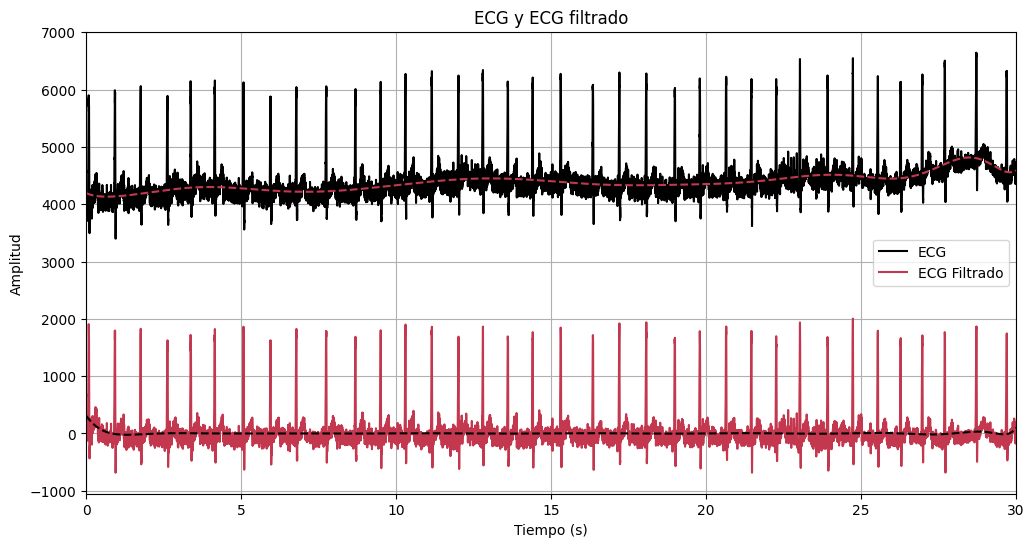

In [ ]:
# Tendencia de la señal sin filtrar
tendency_unfiltered = np.polyfit(tiempo, df_ecg['ECG_asRecording'], 20)
tendency_line_unfiltered = np.polyval(tendency_unfiltered, tiempo)

# Tendencia de la señal filtrada
tendency_filtered = np.polyfit(tiempo, df_ecg['ECG_filtered'], 20)
tendency_line_filtered = np.polyval(tendency_filtered, tiempo)

# Grafica de ECG y ECG filtrado
plt.figure(figsize=(12, 6))
plt.plot(tiempo, df_ecg['ECG_asRecording'], label='ECG', color='k')
plt.plot(tiempo, df_ecg['ECG_filtered'], label='ECG Filtrado', color='#C4384F')
plt.plot(tiempo, tendency_line_unfiltered, color='#C4384F', linestyle='--')
plt.plot(tiempo, tendency_line_filtered, color='k', linestyle='--')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim(0, 30)
plt.title('ECG y ECG filtrado')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-33-e4d0e78f4064>:2: RankWarning: Polyfit may be poorly conditioned
  tendency_unfiltered = np.polyfit(tiempo, df_ecg['ECG_asRecording'], 20)
<ipython-input-33-e4d0e78f4064>:6: RankWarning: Polyfit may be poorly conditioned
  tendency_filtered = np.polyfit(tiempo, df_ecg['ECG_filtered'], 20)


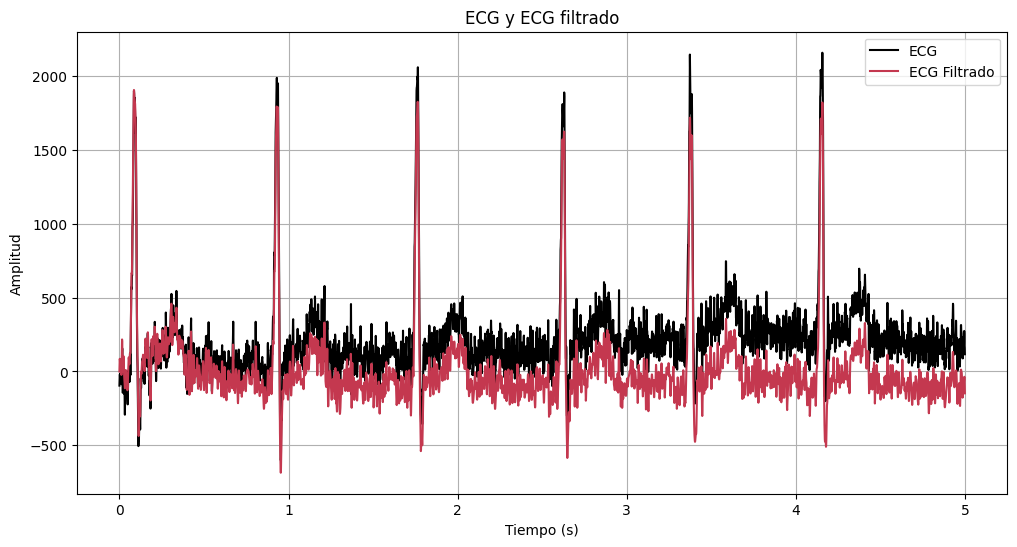

In [ ]:
# Grafica de primeros 5 segundos ECG y ECG filtrado (para que se note mas.
plt.figure(figsize=(12, 6))
plt.plot(tiempo[:int(len(tiempo)/6)], df_ecg['ECG_asRecording'][:int(len(tiempo)/6)]-4000, label='ECG', color='k')
plt.plot(tiempo[:int(len(tiempo)/6)], df_ecg['ECG_filtered'][:int(len(tiempo)/6)], label='ECG Filtrado', color='#C4384F')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('ECG y ECG filtrado')
plt.legend()
plt.grid(True)
plt.show()

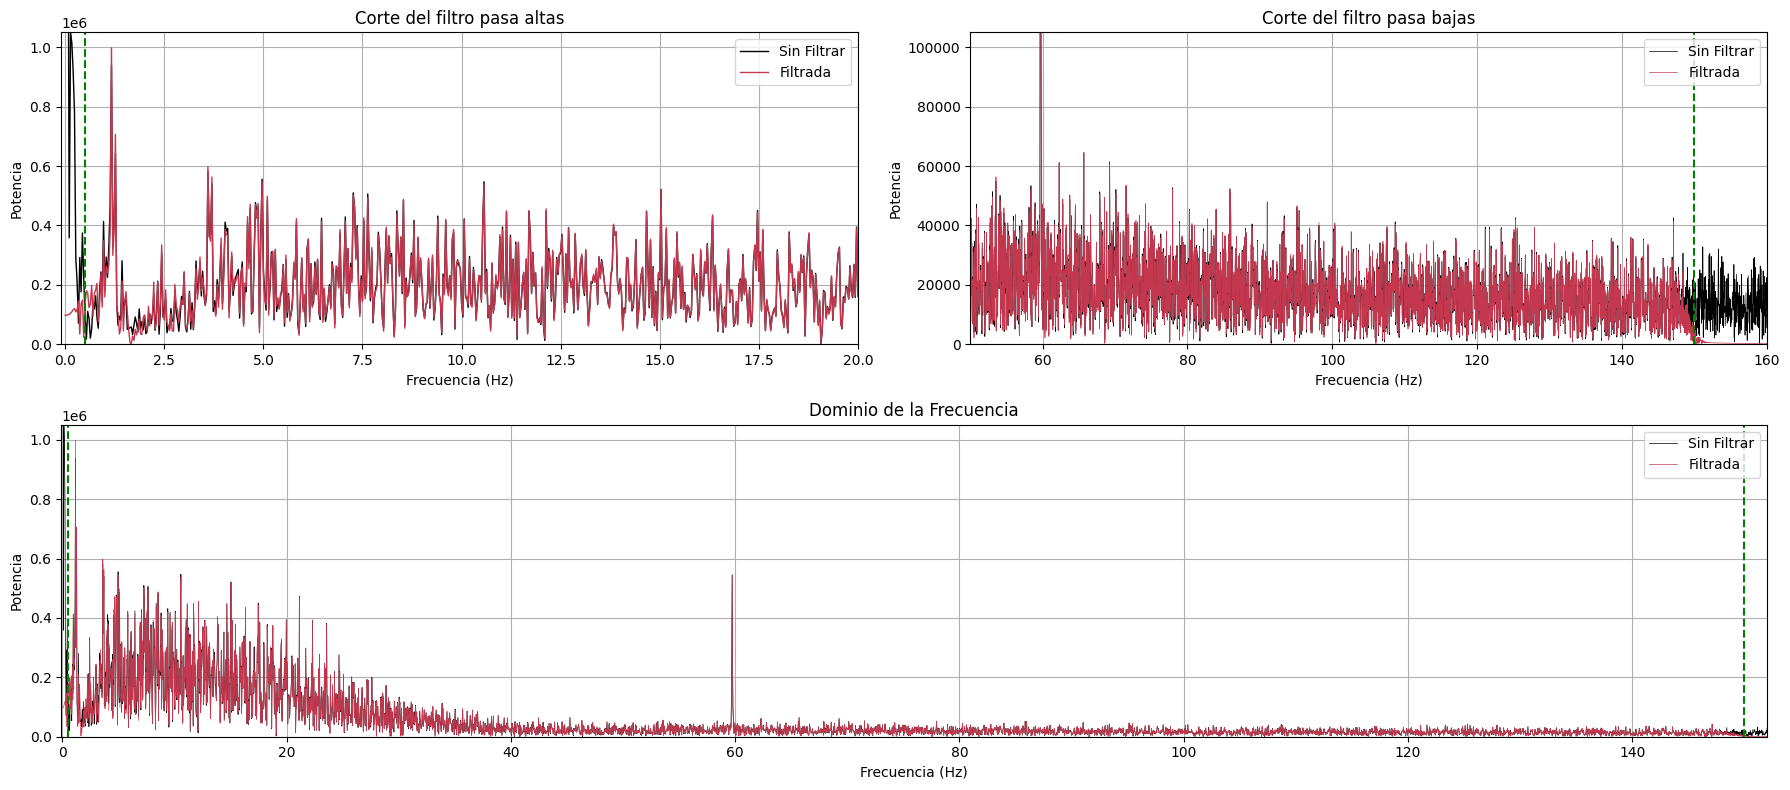

In [ ]:
# ANÁLISIS DEL FILTRO EN EL DOMINIO DE LA FRECUENCIA
# Calcular la FFT de la señal sin filtrar
fft_unfiltered = np.fft.fft(df_ecg['ECG_asRecording'])
# Calcular la FFT de la señal filtrada
fft_filtered = np.fft.fft(df_ecg['ECG_filtered'])

frequencies = np.fft.fftfreq(len(df_ecg), d=1/fs)

# GRAFICAR LAS SEÑALES EN EL DOMINIO DE LA FRECUENCIA
plt.figure(figsize=(18, 8))

# Corte del pasa altas
plt.subplot(2, 2, 1)
# Se grafican solo las frecuencias positivas
plt.plot(frequencies[:len(frequencies)//2],
         np.abs(fft_unfiltered[:len(fft_unfiltered)//2]), color='k', linewidth=1, label='Sin Filtrar')
plt.plot(frequencies[:len(frequencies)//2],
         np.abs(fft_filtered[:len(fft_filtered)//2]), color='#C4384F', linewidth=1, label='Filtrada')
# Frecuencias de interes en un ECG
plt.vlines(x=0.5, ymin=0, ymax=1.05e6, color='green', linestyle='--')
plt.title('Corte del filtro pasa altas')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia')
plt.ylim(0, 1.05e6)
plt.xlim(-0.1, 20)
plt.grid(True)
plt.legend()


# Corte del pasa bajas
plt.subplot(2, 2, 2)
# Se grafican solo las frecuencias positivas
plt.plot(frequencies[:len(frequencies)//2],
         np.abs(fft_unfiltered[:len(fft_unfiltered)//2]), color='k', linewidth=0.5, label='Sin Filtrar')
plt.plot(frequencies[:len(frequencies)//2],
         np.abs(fft_filtered[:len(fft_filtered)//2]), color='#C4384F', linewidth=0.5, label='Filtrada')
# Frecuencias de interes en un ECG
plt.vlines(x=150, ymin=0, ymax=5e6, color='green', linestyle='--')
plt.title('Corte del filtro pasa bajas')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia')
plt.ylim(0, 1.05e5)
plt.xlim(50, 160)
plt.grid(True)
plt.legend()

# Comparación de las señales completas
plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2],
         np.abs(fft_unfiltered[:len(fft_unfiltered)//2]), color='k', linewidth=0.5, label='Sin Filtrar')
plt.plot(frequencies[:len(frequencies)//2],
         np.abs(fft_filtered[:len(fft_filtered)//2]), color='#C4384F', linewidth=0.5, label='Filtrada')
plt.vlines(x=0.5, ymin=0, ymax=5e6, color='green', linestyle='--')
plt.vlines(x=150, ymin=0, ymax=5e6, color='green', linestyle='--')
plt.title('Dominio de la Frecuencia')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia')
plt.ylim(0, 1.05e6)
plt.xlim(-0.1, 152)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def buscarPicos(senal, fs, limite):
  picos, _ = find_peaks(senal, distance= fs *( 30 / 60 ))
  picos_filtrados = senal[picos].loc[senal.gt(limite)]
  return picos_filtrados

In [ ]:
def calcularCiclo(senal, pico, fs):
  # Definir la longitud de un ciclo cardiaco (aproximado)
  longitud_ciclo = int(0.8 * fs) # Duración aproximada de un ciclo en muestras

  # Graficar el primer ciclo cardíaco
  inicio_ciclo = max(0, pico - int(longitud_ciclo/2))
  fin_ciclo = min(len(tiempo), pico + int(longitud_ciclo/2))

  tiempo_ciclo = tiempo[inicio_ciclo:fin_ciclo]
  ecg_ciclo = senal[inicio_ciclo:fin_ciclo]

  return tiempo_ciclo, ecg_ciclo

In [ ]:
def graficarCiclo(pico, tiempo, senal, fs, color):

  plt.figure(figsize=(12, 6))
  plt.plot(tiempo, senal, color=color)
  plt.xlabel('Tiempo (s)')
  plt.ylabel('Amplitud')
  plt.title('Ciclo Cardíaco (ECG)')
  plt.grid(True)
  plt.show()

In [ ]:
# Calculo promedio, RMS, varianza, desviacion estandar

def calcularEstadisticas(senal):
  mean_ciclo = np.mean(senal)
  rms_ciclo = calcularRMS(senal)
  var_ciclo = np.var(senal)
  std_ciclo = np.std(senal)

  return(
f"""Datos estadísticos del ciclo
Promedio: {mean_ciclo}
RMS: {rms_ciclo}
Varianza: {var_ciclo}
Desviación Estándar: {std_ciclo}"""
)

- Tome la señal tal cual se registró. De dicha señal, seleccione un ciclo cardiaco, grafique. Calcule el promedio, el valor RMS, la varianza y la desviación estándar del ciclo. Analice los resultados.

In [ ]:
picos = buscarPicos(df_ecg['ECG_asRecording'], fs, 1500)

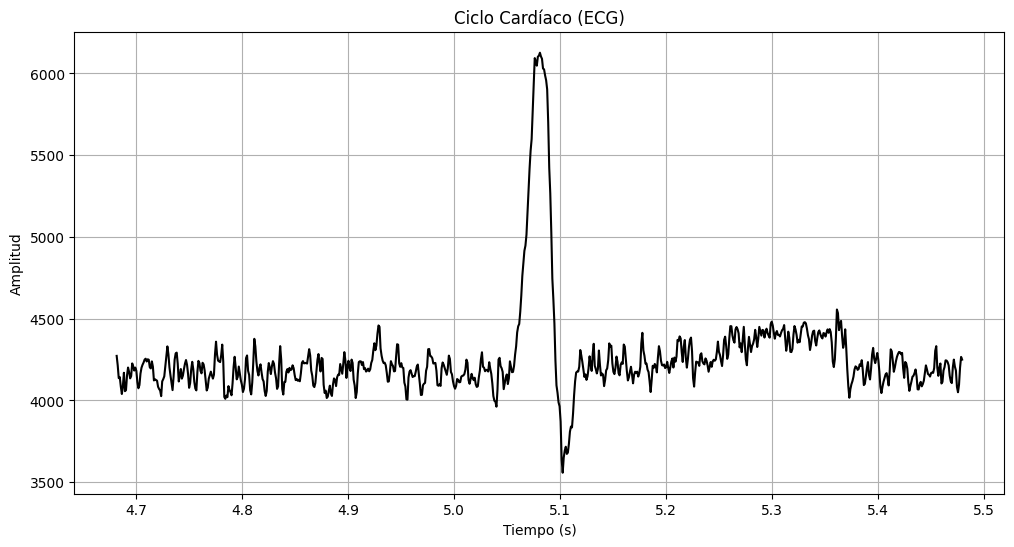

In [ ]:
# Graficar un ciclo

pico = picos.index[6]

tiempo_ciclo, senal_ciclo = calcularCiclo(df_ecg['ECG_asRecording'], pico, fs)

graficarCiclo(pico, tiempo_ciclo, senal_ciclo, fs, 'k')

In [ ]:
print(calcularEstadisticas(senal_ciclo))

Datos estadísticos del ciclo
Promedio: 4262.220610005348
RMS: 4272.980231429451
Varianza: 91835.52983263518
Desviación Estándar: 303.04377543951495


- Tome la señal filtrada. Repita el procedimiento anterior con esta señal, compare con los resultados obtenidos en el ítem anterior.  

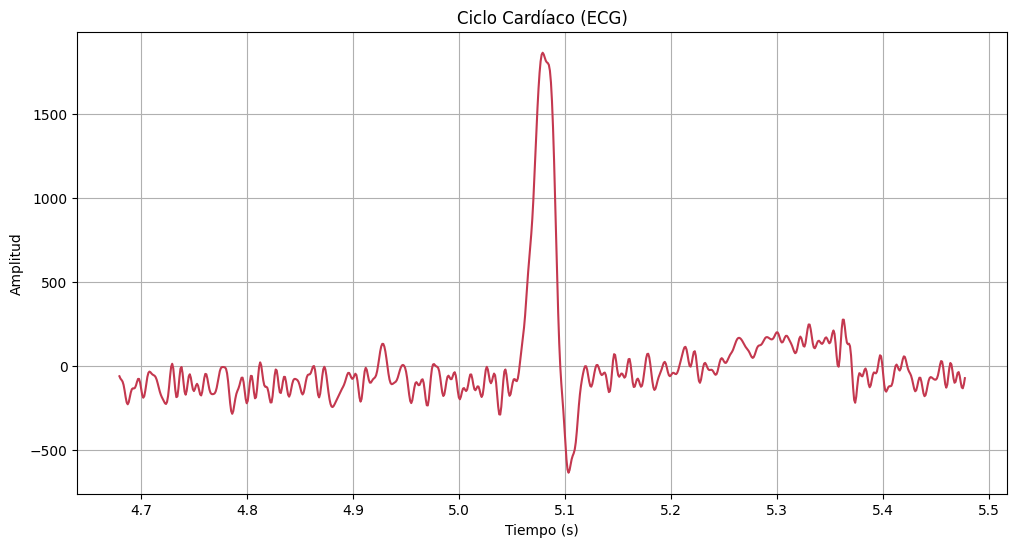

In [ ]:
picos = buscarPicos(df_ecg['ECG_filtered'], fs, 1500)

pico = picos.index[6]

tiempo_ciclo, senal_ciclo = calcularCiclo(df_ecg['ECG_filtered'], pico, fs)

graficarCiclo(pico, tiempo_ciclo, senal_ciclo, fs, '#C4384F')

In [ ]:
print(calcularEstadisticas(senal_ciclo))

Datos estadísticos del ciclo
Promedio: -0.31950498965197055
RMS: 303.0387135743575
Varianza: 91832.35984136286
Desviación Estándar: 303.0385451413118


In [ ]:
def calcularEstadisticasTabla(senal):
  mean_ciclo = np.mean(senal)
  rms_ciclo = calcularRMS(senal)
  var_ciclo = np.var(senal)
  std_ciclo = np.std(senal)

  return({
'promedio': mean_ciclo,
'rms': rms_ciclo,
'varianza': var_ciclo,
'desviacion': std_ciclo
})

- Extraiga 15 ciclos de la señal filtrada, y para cada ciclo calcule el valor promedio y la varianza, grafique cada ciclo, y analice (gráfica y estadísticamente). ¿Se puede considerar que la señal es estacionaria?

In [ ]:
indices_aleatorios = random.sample(range(len(picos)), 15)
picos_aleatorios = picos.iloc[indices_aleatorios]

diccionario_picos = []

indices_aleatorios.sort()
# Iterar sobre los picos aleatorios y graficar los ciclos correspondientes
for i in indices_aleatorios:
    pico = picos.index[i]
    tiempo_ciclo, senal_ciclo = calcularCiclo(df_ecg['ECG_filtered'], pico, fs)
    info_pico = calcularEstadisticasTabla(senal_ciclo)
    info_pico['pico'] = i+1
    diccionario_picos.append(info_pico)

df_picos = pd.DataFrame(diccionario_picos)
df_picos = df_picos[['pico', 'promedio', 'varianza', 'rms', 'desviacion']]

df_picos

,pico,promedio,varianza,rms,desviacion
0,1,180.267848,137101.348151,411.822589,370.271992
1,2,8.432600,88296.657260,297.267163,297.147535
2,5,9.954976,78658.081106,280.637101,280.460480
3,10,13.447980,85878.269433,293.358343,293.049944
4,11,-1.285988,77666.651059,278.690339,278.687372
5,14,-9.800389,93306.794092,305.618785,305.461608
6,16,17.128315,87578.321831,296.431613,295.936348
7,19,27.409072,89367.076195,300.197158,298.943266
8,27,-0.510885,78862.061416,280.824362,280.823898
9,29,-17.517031,86004.731443,293.788321,293.265633


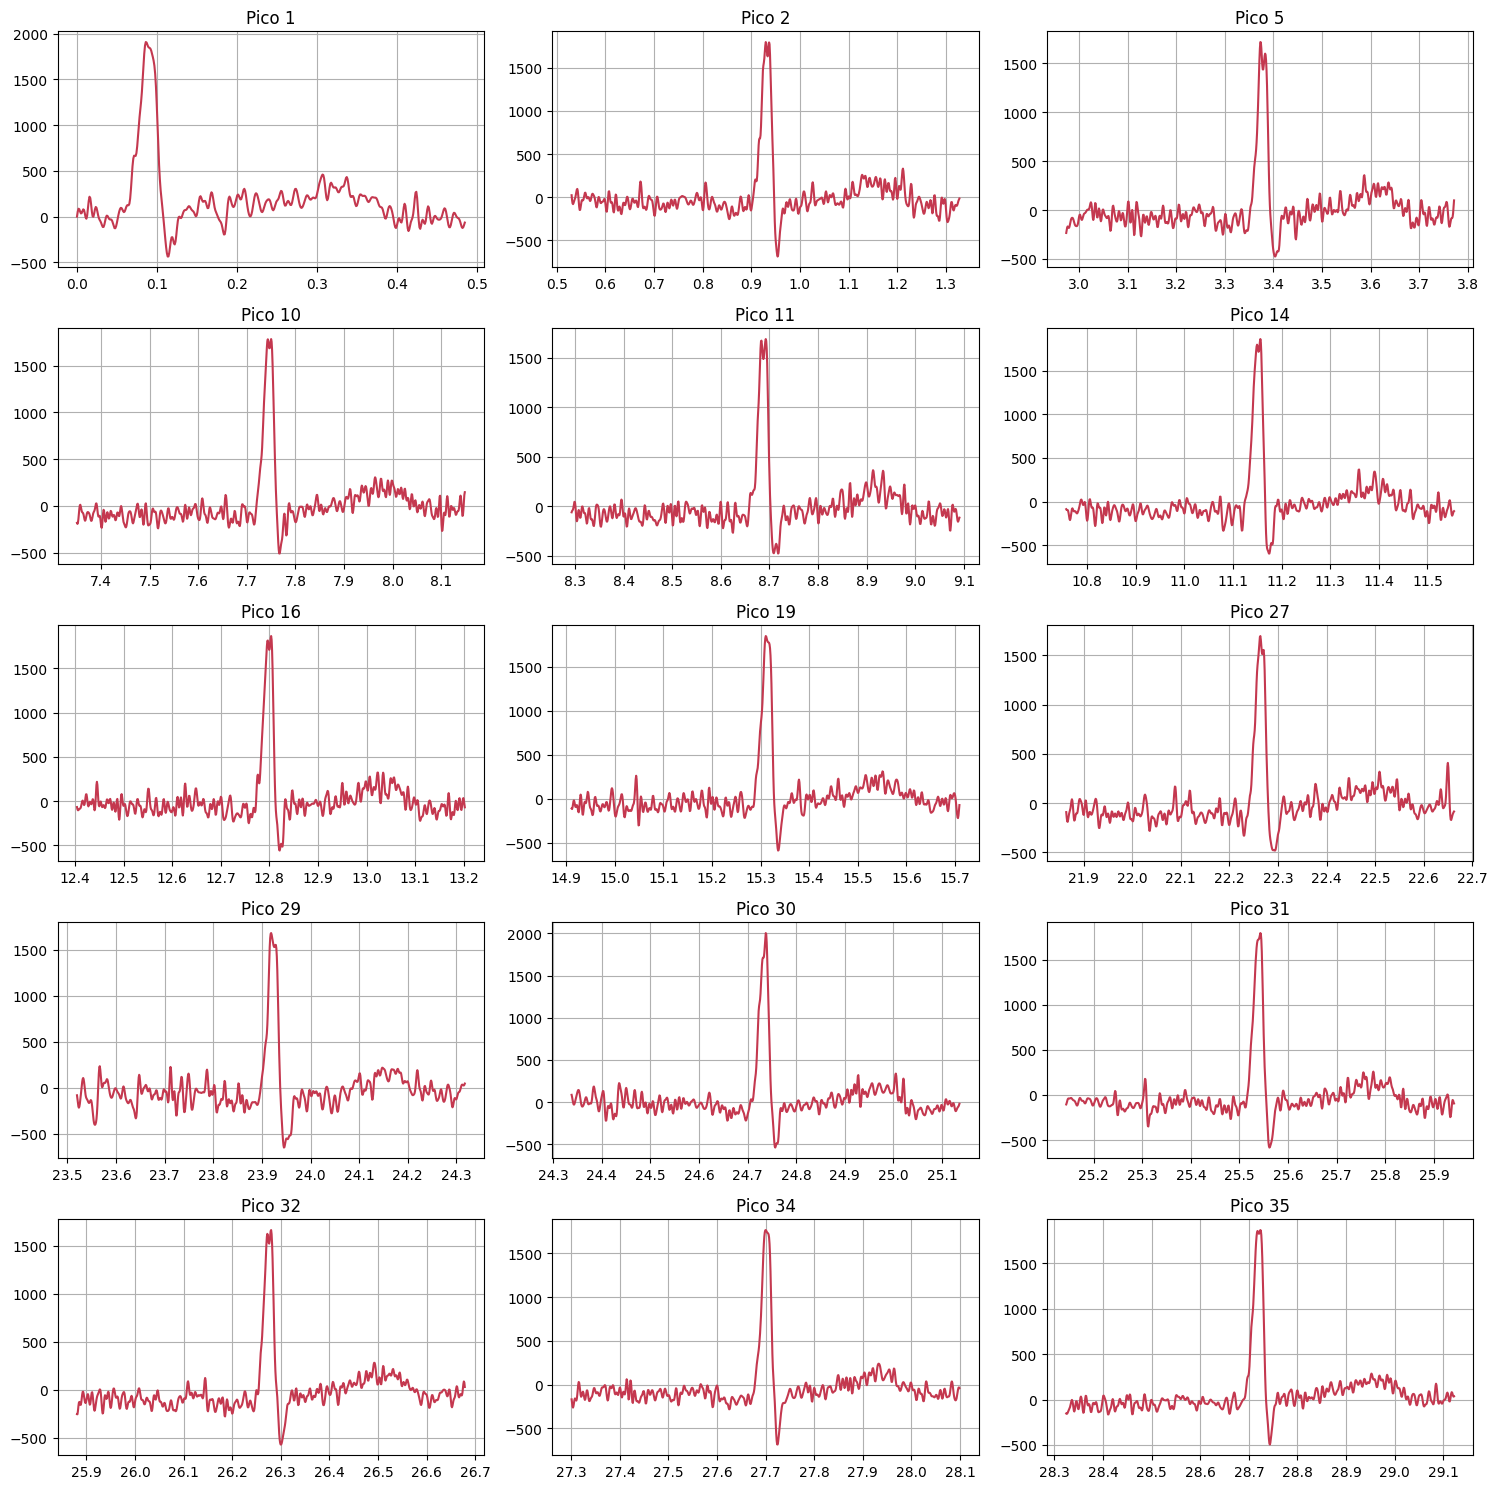

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
  pico_index = indices_aleatorios[i]
  pico = picos.index[pico_index]
  tiempo_ciclo, senal_ciclo = calcularCiclo(df_ecg['ECG_filtered'], pico, fs)
  ax.plot(tiempo_ciclo, senal_ciclo, color='#C4384F')
  ax.set_title(f"Pico {pico_index + 1}")
  ax.grid(True)

plt.tight_layout()
plt.show()


- Realice dos veces comparaciones entre dos ciclos cualquiera utilizando una prueba t. Determine estadísticamente si existe diferencia estadística entre los ciclos, Compruebe los supuestos necesarios para realizar una prueba t, esto es: Normalidad de la variable, independencia (se asume que los grupos son independientes), y homocedasticidad (use una prueba de Levene), finalmente realice la prueba t para determinar si existen diferencias entre los ciclos. Qué indica este análisis respecto de la estacionariedad, explique. De no cumplirse los requisitos, realice entonces un análisis no paramétrico (prueba U de Mann-Whitney).

In [ ]:
# Selección aleatoria de 2 ciclos diferentes entre los 15 ya obtenidos
idx1, idx2, idx3, idx4 = random.sample(range(len(indices_aleatorios)), 4)
pico1 = picos.index[indices_aleatorios[idx1]]
pico2 = picos.index[indices_aleatorios[idx2]]
pico3 = picos.index[indices_aleatorios[idx3]]
pico4 = picos.index[indices_aleatorios[idx4]]

_, ciclo1 = calcularCiclo(df_ecg['ECG_filtered'], pico1, fs)
_, ciclo2 = calcularCiclo(df_ecg['ECG_filtered'], pico2, fs)
_, ciclo3 = calcularCiclo(df_ecg['ECG_filtered'], pico3, fs)
_, ciclo4 = calcularCiclo(df_ecg['ECG_filtered'], pico4, fs)


def estacionariedad(ciclo1, ciclo2):
  print("\nPrueba de normalidad de Shapiro-Wilk")
  shapiro1 = shapiro(ciclo1)
  shapiro2 = shapiro(ciclo2)

  print(f"Ciclo 1: p = {shapiro1.pvalue}")
  print(f"Ciclo 2: p = {shapiro2.pvalue}")

  print("Prueba de homocedasticidad de Levene")
  levene_test = levene(ciclo1, ciclo2)
  print(f"p = {levene_test.pvalue}")

  normal1 = shapiro1.pvalue > 0.05
  normal2 = shapiro2.pvalue > 0.05
  homocedasticos = levene_test.pvalue > 0.05

  print("Prueba de comparación entre ciclos")
  if normal1 and normal2 and homocedasticos:
      print("Ambos ciclos son normales y homocedásticos")
      t_test = ttest_ind(ciclo1, ciclo2)
      print(f"t-test: p = {t_test.pvalue}")
      estacionaria = mw_test.pvalue > 0.05
      print(f"Estacionariedad: {estacionaria}")

  else:
      print("\nSe incumplen supuestos:")
      print(f"Normalidad: Ciclo 1: {normal1}, Ciclo 2: {normal2}")
      print(f"Homocedasticidad: {homocedasticos}")
      mw_test = mannwhitneyu(ciclo1, ciclo2)
      print(f"Mann-Whitney U: p = {mw_test.pvalue}")
      estacionaria = mw_test.pvalue > 0.05
      print(f"Estacionariedad: {estacionaria}")

estacionariedad(ciclo1, ciclo2)
estacionariedad(ciclo3, ciclo4)



Prueba de normalidad de Shapiro-Wilk
Ciclo 1: p = 5.627077183602554e-41
Ciclo 2: p = 5.032781523635657e-41
Prueba de homocedasticidad de Levene
p = 0.8811719919900374
Prueba de comparación entre ciclos

Se incumplen supuestos:
Normalidad: Ciclo 1: False, Ciclo 2: False
Homocedasticidad: True
Mann-Whitney U: p = 0.8259028345305376
Estacionariedad: True

Prueba de normalidad de Shapiro-Wilk
Ciclo 1: p = 1.849030968405912e-42
Ciclo 2: p = 1.517333585627479e-30
Prueba de homocedasticidad de Levene
p = 1.8173366218624294e-05
Prueba de comparación entre ciclos

Se incumplen supuestos:
Normalidad: Ciclo 1: False, Ciclo 2: False
Homocedasticidad: False
Mann-Whitney U: p = 1.8626243172752017e-82
Estacionariedad: False


- Compruebe los resultados anteriores aplicando una prueba de Dickey-Fuller a la señal (Estacionariedad)

In [ ]:
# Aplicando puebra Dickey-Fuller

result = adfuller(df_ecg['ECG_filtered'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] <= 0.05:
    print("La serie es estacionaria")
else:
    print("La serie no es estacionaria")

ADF Statistic: -24.134106752075187
p-value: 0.0
La serie es estacionaria
